In [1]:
from cmocean.cm import thermal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from mhkit import acoustics


P = acoustics.io.read_iclisten("data/acoustics/RBW_6661_20240601_053114.wav")
# P = acoustics.io.read_soundtrap("data/acoustics/6247.230204150508.wav", Sf=-177)


In [2]:
#acoustics.io.export_audio(P)

In [3]:
spsd = acoustics.sound_pressure_spectral_density(P, P.fs)
spsdl = acoustics.sound_pressure_spectral_density_level(spsd)

(<Figure size 600x500 with 1 Axes>,
 <Axes: xlabel='Frequency [Hz]', ylabel='dB re 1 uPa^2/Hz'>)

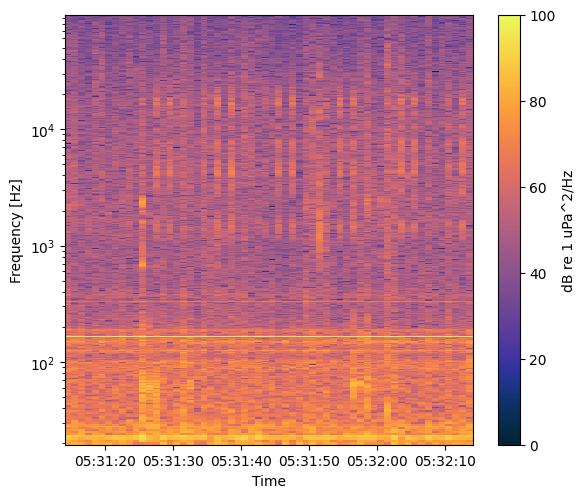

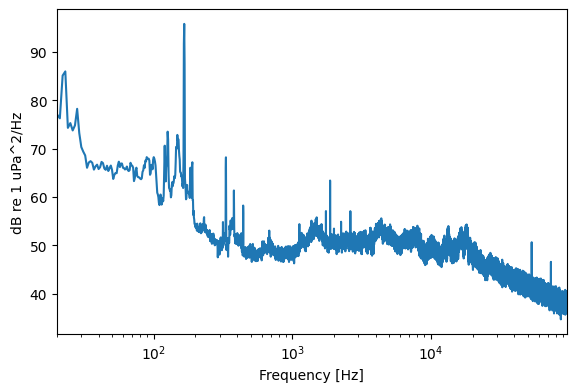

In [4]:
fmin = 20
fmax = 96000

# Create high res spectogram
fig, ax = acoustics.graphics.plot_spectogram(
    spsdl, fmin, fmax, kwargs={"cmap": thermal, "vmin": 0, "vmax": 100}
)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
acoustics.graphics.plot_spectra(spsdl.mean("time"), fmin, fmax)


In [5]:
# Frequency average into # octave bands
octave = 18
spsdl_mean = acoustics.band_average(spsdl, octave, fmin, fmax)

(<Figure size 600x500 with 1 Axes>,
 <Axes: xlabel='Frequency [Hz]', ylabel='dB re 1 uPa^2/Hz'>)

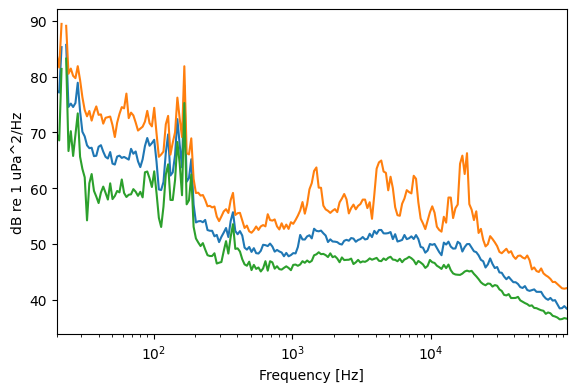

In [6]:

# Time average into 1 min window(s)
window = 60  # 60 s windows
spsdl_50 = acoustics.time_average(spsdl_mean, window, method="median")
spsdl_90 = acoustics.time_average(spsdl_mean, window, method="quantile", method_arg=0.9)
spsdl_10 = acoustics.time_average(spsdl_mean, window, method="quantile", method_arg=0.1)

# Average 10 s spectra
fig, ax = acoustics.graphics.plot_spectra(spsdl_50.mean("time_bins"), fmin, fmax)
acoustics.graphics.plot_spectra(spsdl_90.mean("time_bins"), fmin, fmax, fig, ax)
acoustics.graphics.plot_spectra(spsdl_10.mean("time_bins"), fmin, fmax, fig, ax)


SPL: 102.37689091587322


[Text(0.5, 0, 'Third Octave Frequency Bands [Hz]'),
 Text(0, 0.5, 'Median SPL [dB re 1 uPa]')]

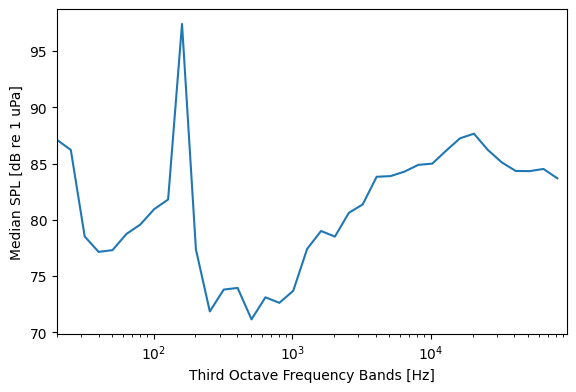

In [7]:
# Sound pressure level
spl = acoustics.sound_pressure_level(spsd, fmin, fmax)
print(f"SPL: {spl.mean().values}")

# Third octave sound pressure level
tospl = acoustics.third_octave_sound_pressure_level(spsd, fmin, fmax)
fig, ax = acoustics.graphics.plot_spectra(tospl.median("time"), fmin, fmax)
ax.set(xlabel="Third Octave Frequency Bands [Hz]", ylabel="Median SPL [dB re 1 uPa]")